### Analyze the Spread of Novel CoronaVirus 
#### Data Source: [Johns Hopkins University](https://drive.google.com/file/d/1ZJCEHKijIMVSJvH74C-LIUJb7BAHqj6b/view)

In [1]:
import pandas as pd

#### Load all sheets in the underlying file

In [2]:
file_path = 'Novel Coronavirus (2019-nCoV) Cases, provided by JHU CSSE.xlsx'

raw_df = pd.concat(pd.read_excel(file_path, sheet_name= None), ignore_index = True, sort=True)

In [3]:
# Merge duplicate columns with different names

main_df = raw_df

main_df.loc[main_df.Deaths.isna(),'Deaths'] =  main_df.loc[main_df.Deaths.isna(),'Demised']

main_df.loc[main_df['Country/Region'].isna(),'Country/Region'] =  main_df.loc[main_df['Country/Region'].isna(),'Country']
main_df.loc[main_df['Country/Region'].isna(),'Country/Region'] =  main_df.loc[main_df['Country/Region'].isna(),'Country_Region']

main_df.loc[main_df['Province/State'].isna(),'Province/State'] =  main_df.loc[main_df['Province/State'].isna(),'Province_State']

main_df.loc[main_df['Last Update'].isna(),'Last Update'] = main_df.loc[main_df['Last Update'].isna(),'Date last updated']
main_df.loc[main_df['Last Update (UTC)'].isna(),'Last Update (UTC)'] = main_df.loc[main_df['Last Update (UTC)'].isna(),'Last_Update']
main_df.loc[main_df['Last Update'].isna(),'Last Update'] = main_df.loc[main_df['Last Update'].isna(),'Last Update (UTC)']

main_df.loc[main_df['Province/State'].isna(), 'Province/State'] = main_df.loc[main_df['Province/State'].isna(), 'Country/Region']

main_df = main_df.loc[:, ~main_df.columns.isin(['Demised' , 'Country' , 'Country_Region','Province_State',
                                                'Date last updated', 'Last Update (UTC)', 'Last_Update',
                                               'Quick note: Starting from this tab, our map is updating (almost) in real time (China data - at least once per hour; non China data - several times per day). This table is planning to be updated twice a day. The discrepancy between the map and this sheet is expected. Sorry for any confusion and inconvenience.'])]
main_df.sample(5)

,Confirmed,Country/Region,Deaths,Last Update,Province/State,Recovered,Suspected,Unnamed: 6,Unnamed: 7
433,1.0,US,NaN,2020-01-31 19:00:00,Washington,NaN,NaN,NaN,NaN
1039,6.0,Macau,NaN,2020-01-27 19:00:00,Macau,NaN,NaN,NaN,NaN
1079,26.0,Mainland China,NaN,2020-01-27 09:00:00,Yunnan,NaN,NaN,NaN,NaN
949,3.0,France,NaN,2020-01-28 13:00:00,France,NaN,NaN,NaN,NaN
470,184.0,Mainland China,NaN,2020-01-31 14:00:00,Shandong,2.0,NaN,NaN,NaN


In [4]:
# merge duplicate country names
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'^China','Mainland China')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'United States','US')

main_df['day'] = main_df['Last Update'].dt.day
main_df['month'] = main_df['Last Update'].dt.month
main_df = main_df.fillna(0) # will take max value in the next step

main_df.sample(5)

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

,Confirmed,Country/Region,Deaths,Last Update,Province/State,Recovered,Suspected,Unnamed: 6,Unnamed: 7,day,month
1045,2.0,US,0.0,2020-01-27 19:00:00,California,0.0,0.0,0.0,0.0,27,1
230,20.0,Japan,0.0,2020-02-01 18:53:00,Japan,1.0,0.0,0.0,0.0,1,2
369,1.0,US,0.0,2020-02-01 10:00:00,Washington,0.0,0.0,0.0,0.0,1,2
1067,75.0,Mainland China,0.0,2020-01-27 09:00:00,Shandong,0.0,0.0,0.0,0.0,27,1
1436,3.0,Mainland China,0.0,2020-01-23 12:00:00,Shaanxi,0.0,1.0,0.0,0.0,23,1


In [5]:
clean_df =main_df.groupby(['Province/State','month','day']).agg({'Last Update':'max',
                                                                  'Confirmed':'max',
                                                                  'Suspected':'max',
                                                                  'Recovered':'max',
                                                                  'Deaths':'max'}).reset_index()

clean_df['period'] = pd.to_datetime('2020-' + clean_df.month.astype(str) + '-' + clean_df.day.astype(str))

clean_df.sample(5)

,Province/State,month,day,Last Update,Confirmed,Suspected,Recovered,Deaths,period
573,Tibet,1,29,2020-01-29 21:00:00,1.0,0.0,0.0,0.0,2020-01-29
174,Hebei,1,23,2020-01-23 12:00:00,1.0,0.0,0.0,1.0,2020-01-23
427,Russia,2,1,2020-02-01 10:00:00,2.0,0.0,0.0,0.0,2020-02-01
606,Washington,1,26,2020-01-26 23:00:00,1.0,0.0,0.0,0.0,2020-01-26
527,Sri Lanka,1,30,2020-01-30 21:30:00,1.0,0.0,0.0,0.0,2020-01-30


#### Some baisc checks

In [6]:
clean_df[clean_df['Province/State'] =='Hubei'].plot.line(x='period', y='Confirmed')

clean_df['Last Update'].value_counts().sort_index()

2020-01-21 00:00:00    27
2020-01-22 12:00:00    38
2020-01-23 12:00:00    46
2020-01-24 12:00:00    40
2020-01-24 16:00:00     1
2020-01-25 12:00:00    42
2020-01-25 22:00:00     2
2020-01-26 23:00:00    47
2020-01-27 09:00:00     1
2020-01-27 20:30:00    52
2020-01-28 18:00:00     1
2020-01-28 23:00:00    51
2020-01-29 21:00:00    56
2020-01-30 21:30:00    59
2020-01-31 15:20:00     1
2020-01-31 19:00:00    63
2020-02-01 10:00:00    36
2020-02-01 10:33:00     1
2020-02-01 10:43:00     1
2020-02-01 10:53:00     1
2020-02-01 11:03:00     1
2020-02-01 13:33:00     1
2020-02-01 14:03:00     1
2020-02-01 14:23:00     1
2020-02-01 15:23:00     1
2020-02-01 15:43:00     2
2020-02-01 15:53:00     1
2020-02-01 17:43:00     1
2020-02-01 18:12:00     7
2020-02-01 18:53:00     1
2020-02-01 19:43:00     5
2020-02-01 19:53:00     3
2020-02-01 23:33:00     5
2020-02-01 23:43:00     3
2020-02-02 00:43:00     1
2020-02-02 01:03:00     1
2020-02-02 02:23:00     1
2020-02-02 03:33:00     2
2020-02-02 0

In [7]:
clean_df[clean_df['Confirmed'] >= 8].head()

,Province/State,month,day,Last Update,Confirmed,Suspected,Recovered,Deaths,period
2,Anhui,1,23,2020-01-23 12:00:00,9.0,4.0,0.0,0.0,2020-01-23
3,Anhui,1,24,2020-01-24 12:00:00,15.0,4.0,0.0,0.0,2020-01-24
4,Anhui,1,25,2020-01-25 12:00:00,60.0,4.0,0.0,0.0,2020-01-25
5,Anhui,1,26,2020-01-26 23:00:00,70.0,4.0,0.0,0.0,2020-01-26
6,Anhui,1,27,2020-01-27 20:30:00,106.0,0.0,0.0,0.0,2020-01-27


#### Some Analysis on spread and recovery

##### Growth rate of confirmed cases

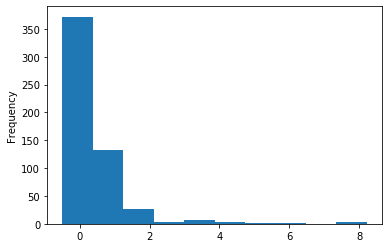

In [8]:
clean_df['Confirmed_lag'] = clean_df.groupby(['Province/State']).Confirmed.shift(1)

clean_df['growth number daily'] =  clean_df.Confirmed - clean_df.Confirmed_lag

clean_df['growth rate daily'] = clean_df.Confirmed / clean_df.Confirmed_lag - 1

clean_df[clean_df.Confirmed_lag > 0]['growth rate daily'].plot.hist()

In [9]:
clean_df['growth rate daily'].describe()

count    566.000000
mean            inf
std             NaN
min       -0.500000
25%        0.000000
50%        0.208657
75%        0.551542
max             inf
Name: growth rate daily, dtype: float64

In [10]:
# focus on cases where base is above 8
heavy_affect_df = clean_df[clean_df['Confirmed_lag'] >= 8]
heavy_affect_df.describe()

,month,day,Confirmed,Suspected,Recovered,Deaths,Confirmed_lag,growth number daily,growth rate daily
count,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000
mean,1.271186,20.844068,271.132203,1.155932,6.257627,6.040678,215.047458,56.084746,0.353863
std,0.445328,11.917635,1114.975519,6.877655,28.119789,36.846875,915.309344,278.192886,0.606297
min,1.000000,1.000000,8.000000,0.000000,0.000000,0.000000,8.000000,-2.000000,-0.200000
25%,1.000000,3.000000,24.000000,0.000000,0.000000,0.000000,17.000000,3.000000,0.109035
50%,1.000000,27.000000,63.000000,0.000000,1.000000,0.000000,47.000000,11.000000,0.227064
75%,2.000000,29.000000,156.000000,0.000000,3.000000,0.000000,128.000000,27.000000,0.415476
max,2.000000,31.000000,11177.000000,72.000000,295.000000,350.000000,11177.000000,4024.000000,8.222222


In [11]:
heavy_affect_df['day count'] = heavy_affect_df.groupby('Province/State')['period'].rank()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
growth_df = heavy_affect_df.pivot_table(values = 'growth rate daily', index = 'day count', columns='Province/State').reset_index()
growth_df

Province/State,day count,Anhui,Beijing,Chongqing,Fujian,Gansu,Germany,Guangdong,Guangxi,Guizhou,...,Shanxi,Sichuan,Singapore,South Korea,Taiwan,Thailand,Tianjin,Xinjiang,Yunnan,Zhejiang
0,1.0,0.666667,0.400000,2.000000,0.800000,0.357143,-0.20,0.529412,0.434783,0.000000,...,0.444444,0.875000,0.000,0.090909,0.000000,0.000000,0.625000,0.076923,0.727273,1.700000
1,2.0,3.000000,0.571429,1.777778,0.944444,0.263158,0.25,0.230769,0.393939,0.333333,...,0.538462,1.933333,0.600,0.250000,0.125000,0.750000,0.076923,0.214286,0.368421,0.592593
2,3.0,0.166667,0.636364,0.466667,0.685714,0.083333,NaN,0.656250,0.108696,0.250000,...,0.350000,0.568182,0.125,NaN,0.111111,0.000000,0.642857,0.000000,0.692308,1.418605
3,4.0,0.514286,0.416667,0.200000,0.389831,0.115385,NaN,0.849057,0.137255,0.933333,...,0.296296,0.304348,0.000,NaN,0.000000,0.000000,0.086957,0.058824,0.250000,0.230769
4,5.0,0.433962,0.333333,0.113636,0.231707,0.206897,NaN,0.489796,0.344828,0.000000,...,0.114286,0.200000,NaN,NaN,NaN,0.357143,0.080000,0.333333,0.381818,0.351562
5,6.0,0.315789,0.176471,0.122449,0.000000,0.142857,NaN,0.034247,0.115385,0.586207,...,0.205128,0.314815,NaN,NaN,NaN,0.000000,0.185185,NaN,0.092105,0.710983
6,7.0,0.185000,0.137500,0.248485,0.188119,0.275000,NaN,0.596026,0.011494,NaN,...,0.191489,0.246479,NaN,NaN,NaN,NaN,0.000000,NaN,0.120482,0.445946
7,8.0,0.000000,0.219780,0.155340,0.200000,NaN,NaN,0.290456,0.136364,NaN,...,0.178571,0.000000,NaN,NaN,NaN,NaN,0.500000,NaN,0.129032,0.254673
8,9.0,0.253165,0.090090,0.100840,0.104167,NaN,NaN,0.263666,0.270000,NaN,...,NaN,0.169492,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.001862
9,10.0,0.373737,0.148760,0.145038,NaN,NaN,NaN,0.109415,0.000000,NaN,...,NaN,0.115942,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.113383


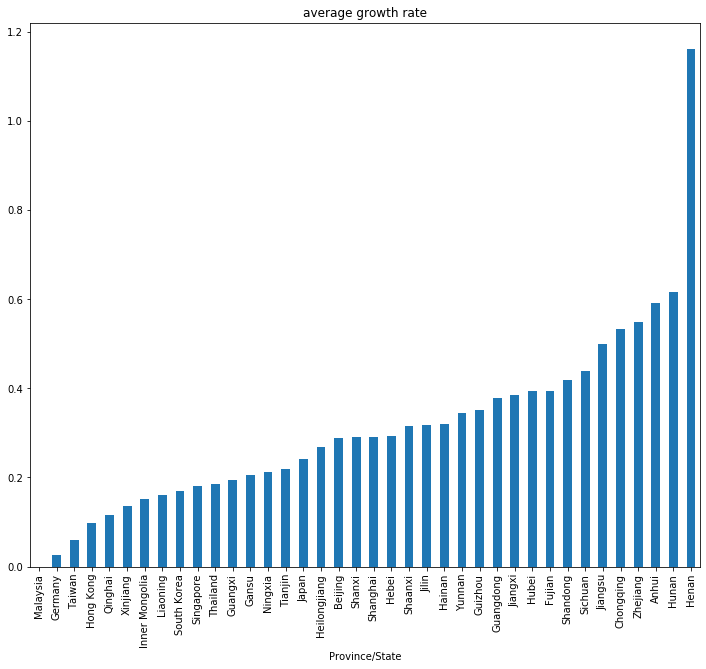

In [13]:
# arithmatic mean of growth rate
growth_df.set_index('day count').mean().sort_values().plot.bar(figsize=(12,10),
                                                              title='average growth rate')

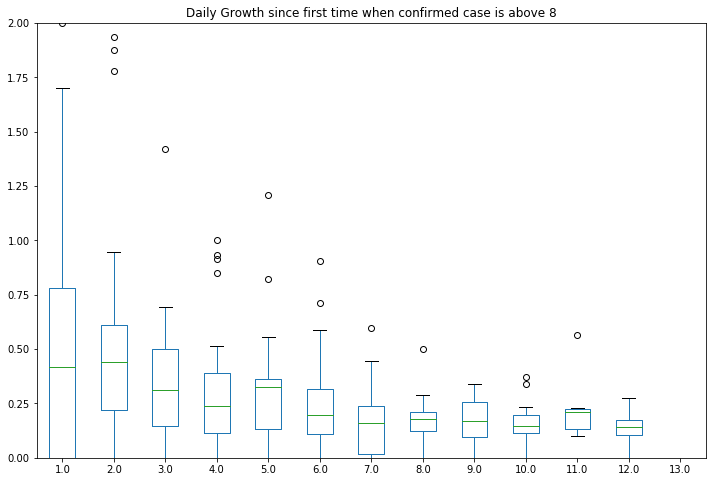

In [14]:
growth_df.set_index('day count').transpose().plot.box(figsize =(12, 8), 
                                         title ='Daily Growth since first time when confirmed case is above 8',
                                         ylim =(0, 2))

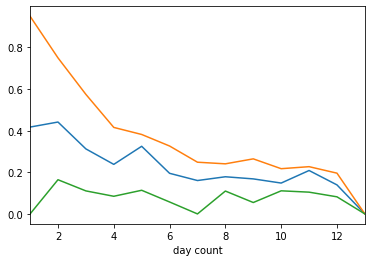

In [15]:
# deceleration? caveat: ommision bias

growth_df.set_index('day count').median(axis =1).plot()
growth_df.set_index('day count').quantile(q=0.8, axis =1).plot()
growth_df.set_index('day count').quantile(q=0.2, axis =1).plot()

In [16]:
# cumulative growth rate from base of the first time there is more than 8 "confirmed case"
earliest_df = heavy_affect_df. \
            groupby(['Province/State']). \
            agg({'Confirmed':'min'}).reset_index().rename(columns ={'Confirmed': 'base'})

earliest_df.sort_values(by='base',ascending=False).head()

,Province/State,base
14,Hubei,444.0
12,Henan,83.0
26,Shandong,39.0
19,Jiangxi,36.0
7,Guangxi,33.0


In [17]:
heavy_affect_df = pd.merge(heavy_affect_df, earliest_df, how = 'left', left_on = 'Province/State', right_on = 'Province/State')
heavy_affect_df

,Province/State,month,day,Last Update,Confirmed,Suspected,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily,day count,base
0,Anhui,1,24,2020-01-24 12:00:00,15.0,4.0,0.0,0.0,2020-01-24,9.0,6.0,0.666667,1.0,15.0
1,Anhui,1,25,2020-01-25 12:00:00,60.0,4.0,0.0,0.0,2020-01-25,15.0,45.0,3.000000,2.0,15.0
2,Anhui,1,26,2020-01-26 23:00:00,70.0,4.0,0.0,0.0,2020-01-26,60.0,10.0,0.166667,3.0,15.0
3,Anhui,1,27,2020-01-27 20:30:00,106.0,0.0,0.0,0.0,2020-01-27,70.0,36.0,0.514286,4.0,15.0
4,Anhui,1,28,2020-01-28 23:00:00,152.0,0.0,0.0,0.0,2020-01-28,106.0,46.0,0.433962,5.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,Zhejiang,1,29,2020-01-29 21:00:00,428.0,0.0,4.0,0.0,2020-01-29,296.0,132.0,0.445946,7.0,27.0
291,Zhejiang,1,30,2020-01-30 21:30:00,537.0,0.0,9.0,0.0,2020-01-30,428.0,109.0,0.254673,8.0,27.0
292,Zhejiang,1,31,2020-01-31 19:00:00,538.0,0.0,14.0,0.0,2020-01-31,537.0,1.0,0.001862,9.0,27.0
293,Zhejiang,2,1,2020-02-01 10:53:00,599.0,0.0,21.0,0.0,2020-02-01,538.0,61.0,0.113383,10.0,27.0


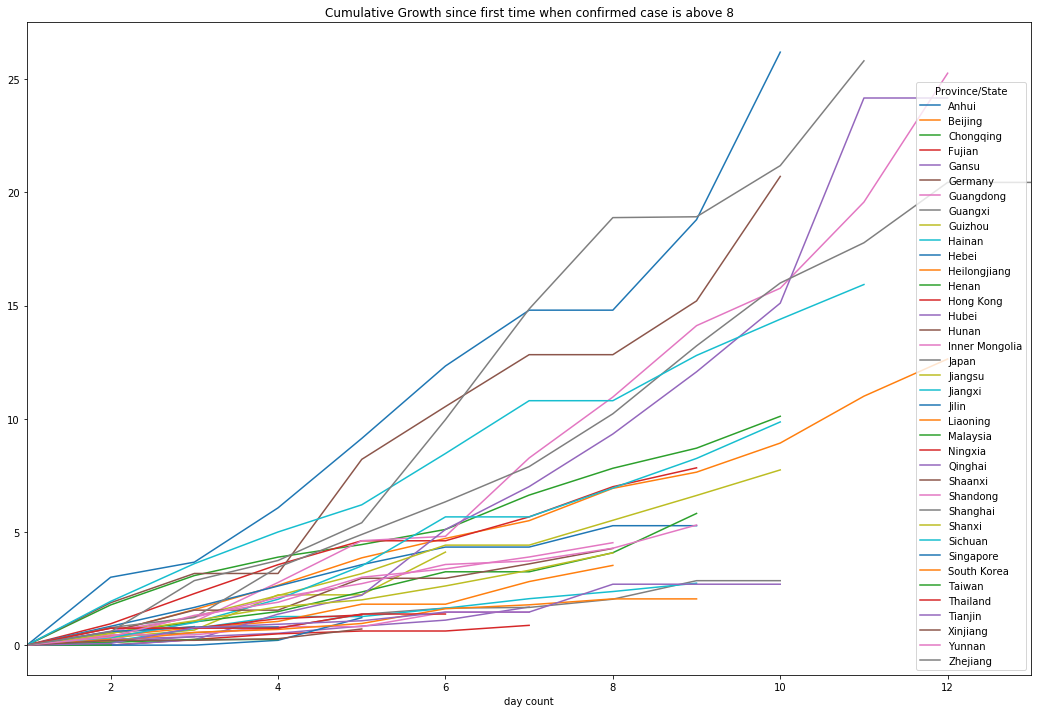

In [18]:
heavy_affect_df['cumulative growth'] = heavy_affect_df['Confirmed']/ heavy_affect_df['base'] - 1
cmlt_growth_df = heavy_affect_df.pivot_table(columns ='Province/State', index= 'day count', values='cumulative growth')
cmlt_growth_df.plot.line(figsize =(18, 12), 
                                         title ='Cumulative Growth since first time when confirmed case is above 8')

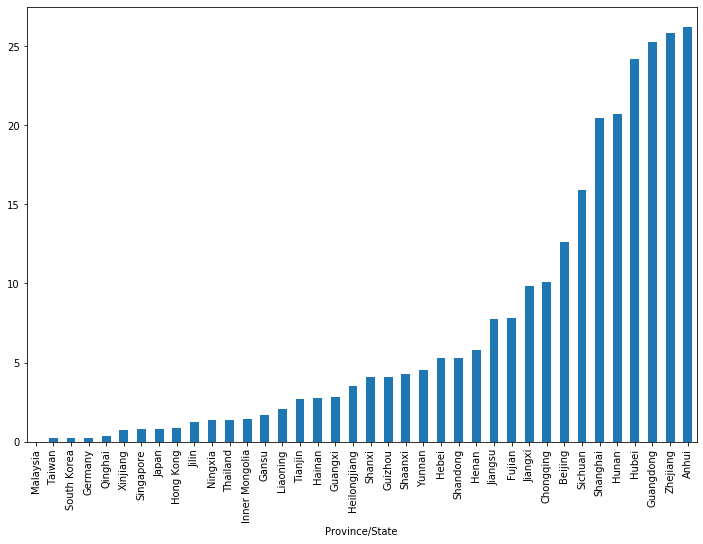

In [19]:
cmlt_growth_df.max().sort_values().plot.bar(figsize =(12,8))

In [20]:
cmlt_growth_df.max().sort_values().index

Index(['Malaysia', 'Taiwan', 'South Korea', 'Germany', 'Qinghai', 'Xinjiang',
       'Singapore', 'Japan', 'Hong Kong', 'Jilin', 'Ningxia', 'Thailand',
       'Inner Mongolia', 'Gansu', 'Liaoning', 'Tianjin', 'Hainan', 'Guangxi',
       'Heilongjiang', 'Shanxi', 'Guizhou', 'Shaanxi', 'Yunnan', 'Hebei',
       'Shandong', 'Henan', 'Jiangsu', 'Fujian', 'Jiangxi', 'Chongqing',
       'Beijing', 'Sichuan', 'Shanghai', 'Hunan', 'Hubei', 'Guangdong',
       'Zhejiang', 'Anhui'],
      dtype='object', name='Province/State')

In [21]:
# the following provinces/states have the highest cumulative growth
cmlt_growth_df[['Jiangxi', 'Chongqing',
       'Beijing', 'Sichuan', 'Shanghai', 'Hunan', 'Hubei', 'Guangdong',
       'Zhejiang', 'Anhui']]

Province/State,Jiangxi,Chongqing,Beijing,Sichuan,Shanghai,Hunan,Hubei,Guangdong,Zhejiang,Anhui
day count,,,,,,,,,,
1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.333333,1.777778,0.571429,1.933333,0.777778,1.875000,0.000000,0.230769,0.592593,3.000000
3.0,1.000000,3.074074,1.571429,3.600000,1.222222,3.166667,0.236486,1.038462,2.851852,3.666667
4.0,2.027778,3.888889,2.642857,5.000000,3.444444,3.166667,1.369369,2.769231,3.740741,6.066667
5.0,3.500000,4.444444,3.857143,6.200000,4.888889,8.208333,2.204955,4.615385,5.407407,9.133333
6.0,5.666667,5.111111,4.714286,8.466667,6.333333,10.541667,5.112613,4.807692,9.962963,12.333333
7.0,5.666667,6.629630,5.500000,10.800000,7.888889,12.833333,7.004505,8.269231,14.851852,14.800000
8.0,6.944444,7.814815,6.928571,10.800000,10.222222,12.833333,9.328829,10.961538,18.888889,14.800000
9.0,8.250000,8.703704,7.642857,12.800000,13.222222,15.208333,12.076577,14.115385,18.925926,18.800000


In [22]:
clean_df[clean_df['Province/State'] =='Hubei']

,Province/State,month,day,Last Update,Confirmed,Suspected,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily
225,Hubei,1,21,2020-01-21 00:00:00,270.0,11.0,0.0,0.0,2020-01-21,NaN,NaN,NaN
226,Hubei,1,22,2020-01-22 12:00:00,444.0,0.0,0.0,0.0,2020-01-22,270.0,174.0,0.644444
227,Hubei,1,23,2020-01-23 12:00:00,444.0,0.0,28.0,17.0,2020-01-23,444.0,0.0,0.000000
228,Hubei,1,24,2020-01-24 12:00:00,549.0,0.0,31.0,24.0,2020-01-24,444.0,105.0,0.236486
229,Hubei,1,25,2020-01-25 22:00:00,1052.0,0.0,42.0,52.0,2020-01-25,549.0,503.0,0.916211
230,Hubei,1,26,2020-01-26 23:00:00,1423.0,0.0,44.0,76.0,2020-01-26,1052.0,371.0,0.352662
231,Hubei,1,27,2020-01-27 20:30:00,2714.0,0.0,47.0,100.0,2020-01-27,1423.0,1291.0,0.907238
232,Hubei,1,28,2020-01-28 23:00:00,3554.0,0.0,80.0,125.0,2020-01-28,2714.0,840.0,0.309506
233,Hubei,1,29,2020-01-29 21:00:00,4586.0,0.0,90.0,162.0,2020-01-29,3554.0,1032.0,0.290377
234,Hubei,1,30,2020-01-30 21:30:00,5806.0,0.0,116.0,204.0,2020-01-30,4586.0,1220.0,0.266027


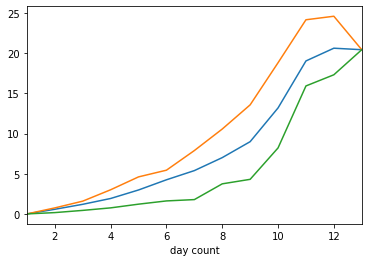

In [23]:
# deceleration? (caveat: ommited variable)
cmlt_growth_df.mean(axis=1).plot()
cmlt_growth_df.quantile(q=0.8,axis=1).plot()
cmlt_growth_df.quantile(q=0.2,axis=1).plot()

##### Recover rate using the latest data available

In [24]:
clean_df['recover rate'] = clean_df.Recovered / clean_df.Confirmed
latest_df = clean_df.groupby(['Province/State']).agg({'Last Update': 'max'}).reset_index()
latest_df

,Province/State,Last Update
0,Anhui,2020-02-02 18:03:00
1,Arizona,2020-02-01 10:00:00
2,Australia,2020-01-27 09:00:00
3,Bavaria,2020-02-01 10:00:00
4,Beijing,2020-02-02 23:43:00
...,...,...
73,Vietnam,2020-02-01 10:00:00
74,Washington,2020-02-01 10:00:00
75,Xinjiang,2020-02-02 00:43:00
76,Yunnan,2020-02-02 18:03:00


In [25]:
latest_df = pd.merge(clean_df, latest_df, how = 'right', left_on = ['Province/State', 'Last Update'], right_on = ['Province/State', 'Last Update'])
latest_df

,Province/State,month,day,Last Update,Confirmed,Suspected,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily,recover rate
0,Anhui,2,2,2020-02-02 18:03:00,408.0,0.0,7.0,0.0,2020-02-02,297.0,111.0,0.373737,0.017157
1,Arizona,2,1,2020-02-01 10:00:00,1.0,0.0,0.0,0.0,2020-02-01,1.0,0.0,0.000000,0.000000
2,Australia,1,27,2020-01-27 09:00:00,5.0,0.0,0.0,0.0,2020-01-27,4.0,1.0,0.250000,0.000000
3,Bavaria,2,1,2020-02-01 10:00:00,7.0,0.0,0.0,0.0,2020-02-01,7.0,0.0,0.000000,0.000000
4,Beijing,2,2,2020-02-02 23:43:00,191.0,0.0,9.0,1.0,2020-02-02,168.0,23.0,0.136905,0.047120
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Vietnam,2,1,2020-02-01 10:00:00,6.0,0.0,1.0,0.0,2020-02-01,2.0,4.0,2.000000,0.166667
74,Washington,2,1,2020-02-01 10:00:00,1.0,0.0,0.0,0.0,2020-02-01,1.0,0.0,0.000000,0.000000
75,Xinjiang,2,2,2020-02-02 00:43:00,24.0,0.0,0.0,0.0,2020-02-02,18.0,6.0,0.333333,0.000000
76,Yunnan,2,2,2020-02-02 18:03:00,105.0,0.0,3.0,0.0,2020-02-02,93.0,12.0,0.129032,0.028571


Percentage over total confirmed cases: 2.83%


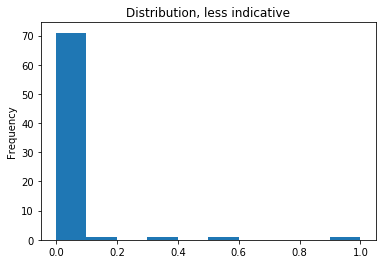

In [26]:
latest_df['recover rate'].plot.hist(title = 'Distribution, less indicative') # not much meaningful data is biased by many cases with very few confirmed case
print('Percentage over total confirmed cases: {0:.2%}'.format(latest_df.Recovered.sum() / latest_df.Confirmed.sum())) # ratio overall is more indicative

#### Time-series Analysis on Growth Rate

In [27]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf

In [28]:
# auto-correlation
[(x, acf(growth_df[x].dropna())) for x in growth_df.columns.to_list()]

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:578: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[:nlags + 1] / avf[0]


[('day count',
  array([ 1.        ,  0.76923077,  0.54395604,  0.32967033,  0.13186813,
         -0.04395604, -0.19230769, -0.30769231, -0.38461538, -0.41758242,
         -0.4010989 , -0.32967033, -0.1978022 ])),
 ('Anhui',
  array([ 1.        , -0.01881144,  0.05356321,  0.00557476, -0.05087029,
         -0.1016219 , -0.1911717 , -0.11317802, -0.08105509, -0.00242952])),
 ('Beijing',
  array([ 1.        ,  0.74154479,  0.42743525,  0.12457214, -0.16230278,
         -0.2184006 , -0.30483878, -0.36019529, -0.30317506, -0.25355139,
         -0.14429984, -0.04678844])),
 ('Chongqing',
  array([ 1.        ,  0.55749959,  0.04163196, -0.09367264, -0.13576275,
         -0.13230895, -0.15451707, -0.22580305, -0.23653539, -0.12053169])),
 ('Fujian',
  array([ 1.        ,  0.69525619,  0.26693767, -0.06627372, -0.32832608,
         -0.36574657, -0.30582608, -0.26509106, -0.13093035])),
 ('Gansu',
  array([ 1.        ,  0.14287603, -0.30958366, -0.20869346, -0.20580271,
         -0.09728158,  0

In [29]:
# unable to run VAR due to missing values (synthetic control?)
model = AutoReg(growth_df['Hubei'].dropna(), lags=1)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  Hubei   No. Observations:                   12
Model:                     AutoReg(1)   Log Likelihood                  -1.746
Method:               Conditional MLE   S.D. of innovations              0.284
Date:                Mon, 03 Feb 2020   AIC                             -1.975
Time:                        19:39:54   BIC                             -1.867
Sample:                             1   HQIC                            -2.043
                                   12                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4940      0.157      3.150      0.002       0.187       0.801
Hubei.L1      -0.2884      0.306     -0.941      0.347      -0.889       0.312
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.4673           +0.0000j            3.4673            0.5000
-----------------------------------------------------------------------------
"""

#### ***Not Used-*** Alternative method choose worksheet before merging

In [30]:
xl = pd.ExcelFile(file_path)
xl.sheet_names

['Feb02_9PM',
 'Feb02_745pm',
 'Feb02_5am',
 'Feb01_11pm',
 'Feb01_6pm',
 'Feb01_10am',
 'Jan31_7pm',
 'Jan31_2pm',
 'Jan30_930pm',
 'Jan30_11am',
 'Jan29_9pm',
 'Jan29_230pm',
 'Jan29_130pm',
 'Jan28_11pm',
 'Jan28_6pm',
 'Jan28_1pm',
 'Jan27_830pm',
 'Jan27_7pm',
 'Jan27_9am',
 'Jan26_11pm',
 'Jan26_11am',
 'Jan25_10pm',
 'Jan25_12pm',
 'Jan25_12am',
 'Jan24_12pm',
 'Jan24_12am',
 'Jan23_12pm',
 'Jan22_12pm',
 'Jan22_12am']

In [31]:
# use the latest time for each date
split_name_df = pd.DataFrame(data = list(map(lambda x: x.split('_'), xl.sheet_names)), columns =['date','hour'])
split_name_df

,date,hour
0,Feb02,9PM
1,Feb02,745pm
2,Feb02,5am
3,Feb01,11pm
4,Feb01,6pm
5,Feb01,10am
6,Jan31,7pm
7,Jan31,2pm
8,Jan30,930pm
9,Jan30,11am


In [32]:
# extract time components
split_name_df['suffix'] = split_name_df.hour.apply(lambda x: x[-2:])

split_name_df['hour_digit'] = split_name_df.hour.str.extract(r'(?P<hour>[\d]+)')

split_name_df['date_digit'] = split_name_df.date.str.extract('([\d]+)').astype(int)

In [33]:
# deal with special case of 12am and half-hour

split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] = split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] - 1

split_name_df['hour_digit'] = split_name_df.hour_digit.str.replace('30','').astype(int)

split_name_df.loc[split_name_df.hour == '12am', 'hour_digit'] = 24

split_name_df.loc[split_name_df.hour == '12am', 'suffix'] = 'pm'

In [34]:
# filter for the last file for each day

filter_name_df = split_name_df[split_name_df.suffix == 'pm']

filter_name_df = filter_name_df.groupby('date_digit').agg({'hour_digit':'max','suffix': 'max'}).reset_index()

filter_name_df

,date_digit,hour_digit,suffix
0,1,11,pm
1,2,745,pm
2,21,24,pm
3,22,12,pm
4,23,24,pm
5,24,24,pm
6,25,12,pm
7,26,11,pm
8,27,8,pm
9,28,11,pm


In [35]:
filter_name_df = pd.merge(split_name_df,filter_name_df, how = 'right', 
         left_on = ['date_digit', 'hour_digit','suffix'], right_on = ['date_digit','hour_digit','suffix'])

filter_name = (filter_name_df.date + '_' + filter_name_df.hour).to_list()
filter_name

['Feb02_745pm',
 'Feb01_11pm',
 'Jan31_7pm',
 'Jan30_930pm',
 'Jan29_9pm',
 'Jan28_11pm',
 'Jan27_830pm',
 'Jan26_11pm',
 'Jan25_12pm',
 'Jan25_12am',
 'Jan24_12am',
 'Jan22_12pm',
 'Jan22_12am']

In [36]:
main_2_df = pd.concat(pd.read_excel(file_path, sheet_name= filter_name), ignore_index = True)
main_2_df['Last Update'].value_counts()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


2020-01-31 19:00:00    63
2020-01-30 21:30:00    59
2020-01-29 21:00:00    56
2020-01-27 20:30:00    52
2020-01-28 23:00:00    51
2020-01-26 23:00:00    47
2020-01-25 12:00:00    44
2020-01-25 00:00:00    44
2020-01-22 12:00:00    38
2020-01-24 00:00:00    38
2020-01-28 18:00:00     1
Name: Last Update, dtype: int64

In [37]:
# def read_excel_sheets(xls_path):
#     """Read all sheets of an Excel workbook and return a single DataFrame"""
#     print(f'Loading {xls_path} into pandas')
#     xl = pd.ExcelFile(xls_path)
#     df = pd.DataFrame()
#     columns = None
#     for idx, name in enumerate(xl.sheet_names):
#         print(f'Reading sheet #{idx}: {name}')
#         sheet = xl.parse(name)
#         if idx == 0:
#             # Save column names from the first sheet to match for append
#             columns = sheet.columns
#         sheet.columns = columns
#         # Assume index of existing data frame when appended
#         df = df.append(sheet, ignore_index=True)
#     return df

# read_excel_sheets(file_name)